The purpose of this notebook is to demonstrate how to refine with locally defined GSAS-II functions.



# General imports

In [1]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time
import glob

import numpy as np
import xarray as xr


from IPython.display import clear_output

In [2]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)


try:
    import ipympl
except:
    !! pip install ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [3]:
try:
    %matplotlib widget
except:
    %matplotlib inline

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# Setting up the example data path

In [4]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except:
    pass

In [5]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/xrd_refinement_with_gsas2/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['gsas.instprm',
 'Ceo2.cif',
 'gsas2_scratch',
 'Pt.cif',
 'Zr.cif',
 'Pt.gpx',
 'LaB6.nc',
 'LaB6.cif',
 'ZrH.nc',
 'Zr-H1.66.cif',
 'Background.nc',
 'ZrH.gpx',
 'Pt.nc',
 'LaB6.gpx']

In [6]:
ls

Background.nc  LaB6.gpx       Pt.gpx         Zr.cif         gsas.instprm
Ceo2.cif       LaB6.nc        Pt.nc          ZrH.gpx        gsas2_scratch/
LaB6.cif       Pt.cif         Zr-H1.66.cif   ZrH.nc


# Setting up GSAS-II package and custom refinement functions

In [7]:
# assuming GSAS-II is installed on the machine on conda
# as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
# as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
# will be installed on a eng location. Then we add it to path as below.

import sys

user = "pmeshkov"

match user:
    case "mtopsakal":
        sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']
    case "pmeshkov":
        sys.path += ['/opt/anaconda3/envs/GSASII/GSAS-II/GSASII']
    case "kmorell"
        sys.path += ['/Users/kevinmorell/g2full/GSAS-II/GSASII']

# we then import GSASIIscriptable
import GSASIIscriptable as G2sc
import pybaselines # this comes with gsas2_package

from IPython.display import clear_output

# clear_output()

GSAS-II binary directory: /opt/anaconda3/envs/GSASII/GSAS-II/GSASII-bin/mac_64_p3.11_n1.26
7 values read from config file /opt/anaconda3/envs/GSASII/GSAS-II/GSASII/config.py
GSASIIplot: wx not imported
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


# Unit Conversion Functions

In [8]:
def twotheta_to_q(twotheta, wavelength):
    twotheta = np.asarray(twotheta)
    wavelength = float(wavelength)
    pre_factor = ((4 * np.pi) / wavelength)
    return pre_factor * np.sin(twotheta / 2)
def q_to_twotheta(q, wavelength):
    q = np.asarray(q)
    wavelength = float(wavelength)
    pre_factor = wavelength / (4 * np.pi)
    return 2 * np.arcsin(q * pre_factor)
def q_to_d(q):
    return (2 * np.pi) / np.asarray(q)
def d_to_q(d):
    return (2 * np.pi) / np.asarray(d)
def twotheta_to_d(twotheta,wavelength):
    th = np.asarray(twotheta)/2
    rad = np.radians(th)
    t = 2*np.sin(rad)
    d = (wavelength)/t
    return d
def tth_wl1_to_wl2(tth1,wl1=0.187,wl2=0.4592):
    """
    scales TwoTheta1 with wavelength1 to TwoTheta1 with wavelength2
    """
    q = twotheta_to_q(np.deg2rad(tth_in), wl1)
    return np.rad2deg(q_to_twotheta(q,wl2))



# HKL Plotting Functions

In [9]:
import pymatgen as mg
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

def hkl_plotter(
    line_axes=None,
    stem_axes=None,
    mp_id=None,
    final=False,
    structure=None,
    str_file=None,
    label=None,
    marker="o",
    color="C0",
    label_x=0.9,
    label_y=0.9,
    unit="2th_deg",
    radial_range=(1, 16),
    bottom=-0.2,
    wl=0.77,
    scale=1,
    scale_a=1,
    scale_b=1,
    scale_c=1,
    export_cif_as=None,
    stem=True,
    stem_logscale=True,
    da_visible=None,
):

    if mp_id is not None:
        from mp_api.client import MPRester

        mpr = MPRester("dHgNQRNYSpuizBPZYYab75iJNMJYCklB")  ###
        structure = mpr.get_structure_by_material_id(mp_id, final=final)[0]
    elif structure is None:
        structure = Structure.from_file(str_file)

    structure.lattice = Lattice.from_parameters(
        a=structure.lattice.abc[0] * scale * scale_a,
        b=structure.lattice.abc[1] * scale * scale_b,
        c=structure.lattice.abc[2] * scale * scale_c,
        alpha=structure.lattice.angles[0],
        beta=structure.lattice.angles[1],
        gamma=structure.lattice.angles[2],
    )

    xrdc = XRDCalculator(wavelength=wl)  ###computes xrd pattern given wavelength , debye scherrer rings, and symmetry precision

    if unit == "q_A^-1":
        ps = xrdc.get_pattern(
            structure,
            scaled=True,
            two_theta_range=np.rad2deg(q_to_twotheta(radial_range, wl)),
        )
        X, Y = twotheta_to_q(np.deg2rad(ps.x), wl), ps.y
    elif unit == "2th_deg":
        ps = xrdc.get_pattern(structure, scaled=True, two_theta_range=radial_range)
        X, Y = ps.x, ps.y
    else:
        ps = xrdc.get_pattern(structure, scaled=True, two_theta_range=radial_range)
        X, Y = ps.x, ps.y

    for axl in line_axes:
        for i in X:
            axl.axvline(x=i, lw=0.6, color=color)
            axl.set_xlim([radial_range[0], radial_range[1]])

    for axs in stem_axes:
        axs_stem = axs.twinx()
        if stem:
            markerline, stemlines, baseline = axs_stem.stem(X, Y, markerfmt=".")
            plt.setp(stemlines, linewidth=0.5, color=color)
            plt.setp(markerline, color=color)
        axs_stem.set_xlim([radial_range[0], radial_range[1]])
        axs_stem.set_yticks([])
        axs_stem.set_ylim(bottom=0.1)
        axs_stem.text(
            label_x, label_y, label, color=color, transform=axs_stem.transAxes
        )

    if export_cif_as is not None:
        structure.to(fmt="cif", filename=export_cif_as)


def phase_plotter(
        wl,
        line_axes=[],
        stem_axes=[],
        radial_range=(1, 16),
        stem=True,
        y_shift=0.1,
        phases=[],
        unit="2th_deg"
):
    for ep, phase in enumerate(phases):
        hkl_plotter(
            line_axes=line_axes,
            stem_axes=stem_axes,
            str_file=phase["cif_abs_path"],
            label=phase["phase_name"],
            scale=phase["scale"],
            marker="o",
            color="C%d" % ep,
            label_x=1.02,
            label_y=ep * y_shift,
            unit=unit,
            radial_range=radial_range,
            bottom=-0.2,
            wl=wl,
            stem=stem,
            stem_logscale=False,
        )


# Functions for navigating the GPX object

In [10]:
"""
Recursively navigate a dictionary and print it as a tree structure.

:param gpx:                 dictionary to be printed
:param indent:              current level of indentation. Used for recursive calls
:param depth:               current depth in the tree, 0 represents the root
"""
def print_dict_as_tree(struct, indent=0, depth=0):
    for key, value in struct.items():
        print(' ' * indent + str(depth) + ". " + str(key))
        if isinstance(value, dict):
            print_dict_as_tree(value, indent + 4, depth + 1)
        else:
            print(' ' * (indent + 4) + str(depth) + ". " + str(value))
"""
Recursively navigate a dictionary-like structure and search for a key. This
doesn't work great if the key is redundant, but is ideal for keys which occur 
only once in the gpx structure

:param struct:              any dictionary, works for GPXd       
:param key:                 the key to find
:returns result:            the value of the key 
"""
def find_key(struct, key):
    if isinstance(struct, dict):
        if key in struct:
            return struct[key]
        else:
            for k, v in struct.items():
                result = find_key(v, key)
                if result is not None:
                    return result
    elif isinstance(struct, list):
        for item in struct:
            result = find_key(item, key)
            if result is not None:
                return result
"""
Recursively navigate a dictionary-like structure and search for a key. This returns
an array of all the structures found stemming from the key. If it reaches a structure
at the lowest level (ie, no subdictionaries are in the structue), containing
the key, returns the structure containing the key. The min_depth and max_depth
thresholds are useful if there are many results, and you need to filter them.

:param d:                   any dictionary, works for GPX       
:param target_key:          the key to find
:param results:             growing list of found structures
:param depth:               depth of a given appended structure
:min_depth:                 sets a minimum depth for collected structures
:min_depth:                 analogous to min depth                 
:returns result:            list of tuples, where each first index represents tells the 
                            depths, and the second index is the structure found; to access
                            a structure at a given index, do find_key(...)[index][1]
"""
def find_instances_of_key(d, target_key, results=None, depth=0, min_depth=0, max_depth=np.inf):
    # instantiates results list
    if results is None:
        results = []

    # checks if we have a dict; if so looks for target key in dict, and continues recursively searching dict 
    if isinstance(d, dict):
        if target_key in d and depth >= min_depth and depth <= max_depth:
            results.append(("Depth " + str(depth), d))
        for key, value in d.items():
            if isinstance(value, dict):
                find_key(value, target_key, results, depth=depth+1, min_depth=min_depth, max_depth=max_depth)
            elif isinstance(value, list):
                for item in value:
                    if isinstance(item, dict):
                        find_key(item, target_key, results, min_depth=min_depth, max_depth=max_depth)

    # checks if we have a list; if so looks for dictionaries in the list and searches them
    elif isinstance(d, list):
        for item in d:
            if isinstance(item, dict):
                find_key(item, target_key, results, min_depth=min_depth, max_depth=max_depth)

    # trys to perform search on dictionary-like object or list
    else:
        try:
            if target_key in d and depth >= min_depth and depth <= max_depth:
                results.append(("Depth " + str(depth), d))
            for key, value in d.items():
                if isinstance(value, dict):
                    find_key(value, target_key, results, depth=depth+1, min_depth=min_depth, max_depth=max_depth)
                elif isinstance(value, list):
                    for item in value:
                        if isinstance(item, dict):
                            find_key(item, target_key, results, depth=depth+1, min_depth=min_depth, max_depth=max_depth)
        except:
            print("Not a valid dictionary.")
            return 0
    return results
def get_valid_phases(gpx):
    """
    Returns valid phases which are present in GPX object, and can 
    be accessed using the `get_cell_constants()` method below
    """
    phases = gpx['Phases']
    return list(phases.keys())[1:]
"""
Navigates a gpx output to search for a phase. Then creates and
returns a convenient lattice constant dictionary which can be 
easily accesed.

:param gpx:                 GSAS project object, has dictionary structure           
"""
def get_cell_consts(gpx, phase, include_angles=False):
    phase_info = gpx['Phases'][phase]
    constants = find_key(phase_info, 'Cell')
    const_dict = {}
    const_dict['a'] = constants[1]
    const_dict['b'] = constants[2]
    const_dict['c'] = constants[3]
    if include_angles:
        const_dict['alpha'] = constants[4]
        const_dict['beta'] = constants[5]
        const_dict['gamma'] = constants[6]
    return const_dict
"""
Prints out each phase, and its respective lattice constants.

:param gpx:                 GSAS project object, has dictionary structure           
"""
def print_all_cell_consts(gpx):
    valid_phases = get_valid_phases(gpx)
    for phase in valid_phases:
        print(phase)
        cell_constants = get_cell_consts(gpx, phase)
        for const in cell_constants:
            print(' ' * 4 + const + ':')
            print(' ' * 8 + str(cell_constants[const]))


In [11]:
"""
Function which plots intensity points at the given d location (X) with 
normalized intensity (Y). It gets these values from the gpx object
created by the GSAS-II extender functions

:param gpx:                  GSAS project object, has dictionary structure
:param line_axes:            axes where to plot points representing peaks
:param stem_axes:            axes where to plot vertical lines representing peaks
:param phases:               string array of phases (can use get_valid_phases(GPX))
:param radial_range:         x axis range
:param marker="o":           marker type
:param stem=True:            boolean representing whether to extend vertical lines
:param unit="d":             unit of the locations
:param plot_unit="q_A^-1":   unit of the plot
:param y_shift=0.1:          y shift of labels in the plot
:returns:                    None
"""
def gpx_plotter(
    gpx,
    line_axes,
    stem_axes,
    phases,
    radial_range,
    marker="o",
    stem=True,
    unit="d",
    plot_unit="q_A^-1",
    y_shift=0.1
):
    for ep, phase in enumerate(phases):
        # getting intensity peak positions (X) and relative magnitudes (Y)
        X = np.array([])
        Y = np.array([])
        for value in gpx['PWDR data.xy']['Reflection Lists'][phase]['RefList']:
            # takes the d column from the Reflection Lists dataframe-like array
            X = np.append(X, value[4])
        # Calculates the intensity maxes and normalized with 100 being the max
        peaks = gpx['PWDR data.xy']['Reflection Lists'][phase]
        Y = peaks['RefList'].T[8]*np.array([refl[11] for refl in peaks['RefList']])
        Imax = np.max(Y)
        if Imax:
            Y *= 100.0/Imax

        if unit == plot_unit:
            continue
        elif unit=="2th_deg" and plot_unit=="q_A^-1":
            X = twotheta_to_q(X, gpx['PWDR data.xy']['Instrument Parameters'][0]['Lam'][ep])
        elif unit=="d" and plot_unit=="q_A^-1":
            X = d_to_q(X)
            
        label=phase
        label_x=1.02
        color="C%d" % ep
        label_y=ep * y_shift
        
        for axl in line_axes:
            for i in X:
                axl.axvline(x=i, lw=0.6, color=color)
                axl.set_xlim([radial_range[0], radial_range[1]])

        for axs in stem_axes:
            axs_stem = axs.twinx()
            if stem:
                markerline, stemlines, baseline = axs_stem.stem(X, Y, markerfmt=".")
                plt.setp(stemlines, linewidth=0.5, color=color)
                plt.setp(markerline, color=color)
            axs_stem.set_xlim([radial_range[0], radial_range[1]])
            axs_stem.set_yticks([])
            axs_stem.set_ylim(bottom=0.1)
            axs_stem.text(
                label_x, label_y, label, color=color, transform=axs_stem.transAxes
            )


# GSAS-II functions (incomplete)
>See for more info https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html#


In [12]:
def PrintwR(gpx,header=''):
    clear_output()
    hist   = gpx.histograms()[0]
    print('\n'+header)
    print("\t{:20s}: {:.2f}".format(hist.name,hist.get_wR()))
    print("")


# def set_limits(gpx,limits=None):
#     gpx.set_refinement({"set":{'Limits': limits}})
#     gpx.save()
#     print('\nlimits are set\n ')

def set_LeBail(gpx,LeBail=False):
    gpx.set_refinement({"set":{'LeBail': LeBail}})
    gpx.save()
    
    print('\nLeBail is set to %s\n '%(LeBail))


def refine_background(gpx,num_coeffs,set_to_false=True):
    try:
        rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    except:
        rwp_old = 'na'

    ParDict = {'set': {'Background': {'refine': True,
                                      'type': 'chebyschev-1',
                                      'no. coeffs': num_coeffs
                                     }}}
    gpx.set_refinement(ParDict)

    gpx.refine(); rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']

    if set_to_false:
        gpx.set_refinement({'set': {'Background': {'refine': False}}})
    gpx.save()
    
    try:
        print('\n\n\nBackground is refined: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))
    except:
        print('\n\n\nBackground is refined: Rwp=%.3f \n\n\n '%(rwp_new))


def refine_cell_params(gpx,phase_ind=None,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    phases = gpx.phases()
    for e,p in enumerate(phases):
        if phase_ind is None:
            gpx['Phases'][p.name]['General']['Cell'][0]= True
        else:
            if e == phase_ind:
                gpx['Phases'][p.name]['General']['Cell'][0]= True
    gpx.refine()
    if set_to_false:
        phases = gpx.phases()
        for p in phases:
            gpx['Phases'][p.name]['General']['Cell'][0]= False
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()
    
    if phase_ind is None:
        print('\n\n\nCell parameters of all phases are refined simultaneously: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))
    else:
        print('\n\n\nCell parameters of phase #d is refined: Rwp=%.3f (was %.3f)\n\n\n '%(phase_ind,rwp_new,rwp_old))


def refine_strain_broadening(gpx,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    ParDict = {'set': {'Mustrain': {'type': 'isotropic',
                                      'refine': True
                                     }}}
    gpx.set_refinement(ParDict)
    gpx.refine()

    if set_to_false:
        ParDict = {'set': {'Mustrain': {'type': 'isotropic',
                                  'refine': False
                                 }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()

    print('\n\n\nStrain broadeing is refined: Rwp=%.3f (was %.3f)\n\n\n '%(rwp_new,rwp_old))


def refine_size_broadening(gpx,set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    ParDict = {'set': {'Size': {'type': 'isotropic',
                                      'refine': True
                                     }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    if set_to_false:
        ParDict = {'set': {'Size': {'type': 'isotropic',
                                  'refine': False
                                 }}}
    gpx.set_refinement(ParDict)
    gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()

    print('\nSize broadening is refined: Rwp=%.3f (was %.3f)\n '%(rwp_new,rwp_old))


def refine_inst_parameters(gpx,inst_pars_to_refine=['X', 'Y', 'Z', 'Zero', 'SH/L', 'U', 'V', 'W'],set_to_false=True):
    rwp_old = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.set_refinement({"set": {'Instrument Parameters': inst_pars_to_refine}})
    gpx.refine()
    if set_to_false:
        ParDict = {"clear": {'Instrument Parameters': ['X', 'Y', 'Z', 'Zero', 'SH/L', 'U', 'V', 'W']}}
        gpx.set_refinement(ParDict)
        gpx.refine()
    rwp_new = gpx['Covariance']['data']['Rvals']['Rwp']
    gpx.save()

    print('\nInstrument parameters %s are refined: Rwp=%.3f (was %.3f)\n '%(inst_pars_to_refine,rwp_new,rwp_old))




def instprm_updater(gpx, gsas2_scratch='gsas2_scratch'):
    instprm_dict = gpx['PWDR data.xy']['Instrument Parameters'][0]
    with open('%s/gsas.instprm'%gsas2_scratch, 'w') as f:
        f.write('#GSAS-II instrument parameter file; do not add/delete items!\n')
        f.write('Type:PXC\n')
        f.write('Bank:1.0\n')
        f.write('Lam:%s\n'%(instprm_dict['Lam'][1]))
        f.write('Polariz.:%s\n'%(instprm_dict['Polariz.'][1]))
        f.write('Azimuth:%s\n'%(instprm_dict['Azimuth'][1]))
        f.write('Zero:%s\n'%(instprm_dict['Zero'][1]))
        f.write('U:%s\n'%(instprm_dict['U'][1]))
        f.write('V:%s\n'%(instprm_dict['V'][1]))
        f.write('W:%s\n'%(instprm_dict['W'][1]))
        f.write('X:%s\n'%(instprm_dict['X'][1]))
        f.write('Y:%s\n'%(instprm_dict['Y'][1]))
        f.write('Z:%s\n'%(instprm_dict['Z'][1]))
        f.write('SH/L:%s\n'%(instprm_dict['SH/L'][1]))


def refiner(nc_path,
            phases,  # should be a dict like [{'cif_abs_path':'/content/drive/MyDrive/XRD-on-colab/_cifs/LaB6.cif','phase_name':'LaB6'}]
            da_input_bkg=None,
            q_range=[0.1, 10.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = None,
            update_ds = True,
            update_gpx=True,
            plot=True
            ):


    if not os.path.isfile('%s/gsas.instprm'%gsas2_scratch):
        print('ERROR:!! gsas.instprm is not found. Please copy one into %s folder.\n\n'%gsas2_scratch)
        return


    with xr.open_dataset(nc_path) as ds:


        for k in ['Y_obs','Y_calc','Y_bkg_auto','Y_bkg_gsas','Y_bkg','Y_bkg_arpls','Y_bkg_auto']:
            if k in ds.keys():
                del ds[k]

        da_i2d = ds.i2d.sel(radial=slice(q_range[0],q_range[1])).astype('float32')
        da_i2d_m = da_i2d.mean(dim='azimuthal')


        if da_input_bkg is None:
            arpls_ = pybaselines.Baseline(x_data=da_i2d_m.radial.values).arpls((da_i2d_m).values, lam=1e5)[0]
            shift_ = min((da_i2d_m).values - arpls_)
            bkg_arpls = (arpls_+shift_)
            bkg_auto = bkg_arpls

        else:
            da_input_bkg = da_input_bkg.sel(radial=slice(q_range[0],q_range[1]))
            blank_scale = (da_i2d_m[0] / da_input_bkg[0]).values
            while (min((da_i2d_m.values-blank_scale*da_input_bkg.values)) < 0):
                blank_scale = blank_scale*0.95

            da_input_bkg_scaled = blank_scale*da_input_bkg

            arpls_ = pybaselines.Baseline(x_data=da_i2d_m.radial.values).arpls((da_i2d_m-da_input_bkg_scaled).values, lam=1e5)[0]
            shift_ = min((da_i2d_m-da_input_bkg_scaled).values - arpls_)
            bkg_arpls = (arpls_+shift_)
            bkg_auto = bkg_arpls + da_input_bkg_scaled.values


        Y_to_gsas = da_i2d_m.values-bkg_auto
        y_scale = 1000/max(Y_to_gsas)
        y_baseline = 10
        Y_to_gsas = y_baseline+Y_to_gsas*y_scale

        X_to_gsas = np.rad2deg(q_to_twotheta(da_i2d_m.radial.values, wavelength=(ds.attrs['wavelength']*1.0e10)))
        np.savetxt('%s/data.xy'%gsas2_scratch, np.column_stack( (X_to_gsas,Y_to_gsas) ), fmt='%.4f %.4f')


        # gpx part
        gpx = G2sc.G2Project(newgpx='%s/gsas.gpx'%gsas2_scratch)
        gpx.data['Controls']['data']['max cyc'] = 100
        gpx.add_powder_histogram('%s/data.xy'%gsas2_scratch,'%s/gsas.instprm'%gsas2_scratch)

        hist   = gpx.histograms()[0]
        for p in phases:
            gpx.add_phase(p['cif_abs_path'],phasename=p['phase_name'], histograms=[hist],fmthint='CIF')
        gpx.save()

        gpx = refinement_recipe(gpx)


        histogram = gpx.histograms()[0]

        gsas_X  = histogram.getdata('x').astype('float32')
        gsas_Yo = histogram.getdata('yobs').astype('float32')
        gsas_Yc = histogram.getdata('ycalc').astype('float32')
        gsas_B  = histogram.getdata('Background').astype('float32')



        # now convert Y back
        Y_Obs_from_gsas  = ((gsas_Yo -y_baseline  )/y_scale )
        Y_Bkg_from_gsas  = ((gsas_B  -y_baseline  )/y_scale )
        Y_calc_from_gsas = ((gsas_Yc -y_baseline  )/y_scale ) # this also includes background from GSAS


        ds = ds.assign_coords(
            {"X_in_q": da_i2d_m.radial.values.astype('float32')},
            )
        ds = ds.assign_coords(
            {"X_in_tth": gsas_X.astype('float32')},
            )
        ds = ds.assign_coords(
            {"X_in_d": q_to_d(da_i2d_m.radial.values.astype('float32'))},
            )


        ds['Y_obs'] = xr.DataArray(
                                    data=da_i2d_m.values,
                                    dims=['X_in_q'],
                                )
        ds['Y_calc'] = xr.DataArray(
                                    data=Y_calc_from_gsas-Y_Bkg_from_gsas,
                                    dims=['X_in_q'],
                                )# by Ycalc, we mean only calculated peaks, no background

        ds['Y_bkg_gsas'] = xr.DataArray(
                                    data=Y_Bkg_from_gsas,
                                    dims=['X_in_q'],
                                )
        ds['Y_bkg_auto'] = xr.DataArray(
                                    data=bkg_auto,
                                    dims=['X_in_q'],
                                )



        with open('%s/gsas.lst'%(gsas2_scratch)) as lst_file:
            gsas_lst = lst_file.read()
            ds.attrs['gsas_lst'] = gsas_lst


    # for e,p in enumerate(gpx.phases()):
    #     p.export_CIF(outputname='%s/%s_from_refinement.cif'%(gsas2_scratch,p.name))
    #     with open('%s/%s_from_refinement.cif'%(gsas2_scratch,p.name)) as cif_file:
    #         ds.attrs['%s_refined_structure'%(p.name)] = cif_file.read()
    #     os.remove('%s/%s_from_refinement.cif'%(gsas2_scratch,p.name))


    if update_ds:
        ds.to_netcdf(nc_path+'.new.nc',engine="scipy")
        time.sleep(0.1)
        shutil.move(nc_path+'.new.nc',nc_path)


    if update_gpx:
        shutil.copyfile(gpx['Controls']['data']['LastSavedAs'],'%s.gpx'%nc_path[:-3])


    if plot:

        # now create a mosaic and plot based on its pattern
        fig = plt.figure(figsize=(8,8),dpi=96)
        mosaic = """
        RRR
        YYY
        YYY
        PPP
        DDD
        """
        ax_dict = fig.subplot_mosaic(mosaic)

        ax = ax_dict["R"]

        np.log(da_i2d).plot.imshow(ax=ax,robust=True,add_colorbar=False,cmap='Greys',vmin=0)
        ax.set_ylabel(ds.i2d.ylabel)
        ax.set_xlabel(None)
        ax.set_xticklabels([])
        ax.set_xlim([q_range[0],q_range[1]])
        Rwp, GoF = gpx.data['Covariance']['data']['Rvals']['Rwp'], gpx.data['Covariance']['data']['Rvals']['GOF']
        ax.set_title('%s\n(R$_{wp}$=%.3f GoF=%.3f)'%(nc_path.split('/')[-1],Rwp,GoF))
        ax.set_facecolor('#FFFED4')

        ax = ax_dict["Y"]
        X, Yobs, Ycalc, Ybkg= ds['X_in_q'].values, ds['Y_obs'].values, ds['Y_calc'].values, (ds['Y_bkg_auto']+ds['Y_bkg_gsas']).values
        ax.plot(X, np.log( Yobs ),label='Y$_{obs}$',lw=2,color='k')
        ax.plot(X, np.log( Ycalc+Ybkg ),label='Y$_{calc}$+Y$_{bkg}$',lw=1,color='y')
        ax.fill_between(X, np.log( Ybkg ),label='Y$_{bkg}$',alpha=0.2)
        ax.set_ylim(bottom=np.log(min(min(Ybkg),min(Ybkg)))-0.1)
        ax.set_xticklabels([])
        ax.set_ylabel('Log$_{10}$(counts) (a.u.)')
        ax.set_xlim([q_range[0],q_range[1]])

        # find lattice constants for each phase and use them for label strings
        phases = get_valid_phases(gpx)
        phase_ct = len(phases)
        label_strs = [None] * phase_ct
        label_colors = [None] * phase_ct
        for ep, phase in enumerate(phases):
            label_strs[ep] = phase
            consts = iter(['a', 'b', 'c'])
            for value in np.unique(list(get_cell_consts(gpx, phase).values())):
                label_strs[ep] = label_strs[ep] + "\n(" + next(consts) + " = " + str(round(value,6)) + ")"
            label_colors[ep] = "C%d" % ep
            
        # create labels for legend as Line2D objects
        from matplotlib.lines import Line2D
        custom_handles = []
        for i in np.arange(0,phase_ct,1):
            custom_handles.append(Line2D([0], [0], marker='o',color=label_colors[i], label='Scatter',
                          markerfacecolor=label_colors[i], markersize=5))

        # get legend handles from the plot and set legend
        handles, labels = ax.get_legend_handles_labels()
        all_handles = handles + custom_handles
        print(label_strs)
        all_labels = labels + label_strs
        ax.legend(all_handles, all_labels)
        
        ax = ax_dict["Y"]
        ax_bottom = ax_dict["P"]
        gpx_plotter(
            gpx,
            line_axes=[ax,ax_bottom],
            stem_axes=[ax_bottom],
            radial_range=q_range,
            phases=get_valid_phases(gpx),
            marker="o",
            stem=True,
            unit="d",
            plot_unit="q_A^-1",
            y_shift=0.1
        )

        ax = ax_dict["Y"]
        ax_bottom = ax_dict["P"]

        ax = ax_dict["D"]
        ax.plot(X, Yobs-Ycalc-Ybkg,label='diff.',lw=1,color='r')
        ax.set_xlabel('Scattering vector $q$ ($\AA^{-1}$)')
        ax.set_ylabel('counts (a.u.)')
        ax.set_xlim([q_range[0],q_range[1]])
        ax.legend(loc='best')


    return [gpx,ds]



# Refinements

In [13]:
os.makedirs('gsas2_scratch',exist_ok=True)

In [14]:
%%writefile gsas2_scratch/gsas.instprm
#GSAS-II instrument parameter file; do not add/delete items!
Type:PXC
Bank:1.0
Lam:0.1824
Polariz.:7.277695011573669
Azimuth:0.0
Zero:-0.00025200085768731445
U:129.15268004188428
V:1.816645496453032
W:0.43034683098418736
X:-0.0661572816525536
Y:-0.9270864296622138
Z:0.02775503495558348
SH/L:0.002

Overwriting gsas2_scratch/gsas.instprm


In [15]:
with xr.open_dataset('Background.nc') as ds:
    da_input_bkg = ds.i2d.mean(dim='azimuthal')

Class to block hide prints in the refinment process.

In [16]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

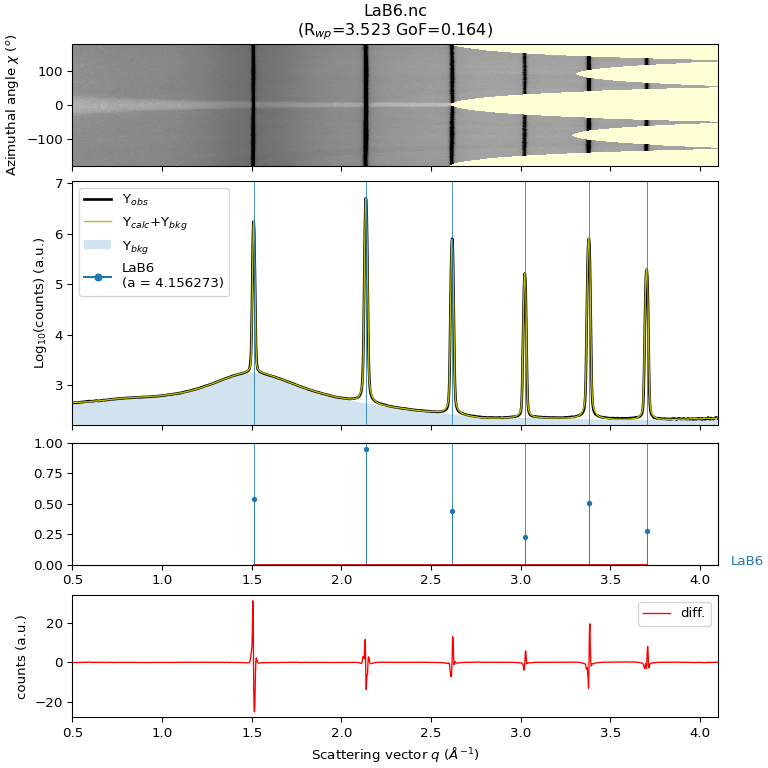

In [17]:
def refinement_recipe(gpx,update_instprm=True):

    refine_background(gpx,num_coeffs=2,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    # refine_size_broadening(gpx,set_to_false=True)
    # refine_strain_broadening(gpx,set_to_false=True)

    for par in ['U', 'V', 'W']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    for par in ['X', 'Y', 'Z']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    for par in ['Zero']:
        refine_inst_parameters(gpx,inst_pars_to_refine=[par])
    if update_instprm:
        instprm_updater(gpx)
    gpx.save()

    refine_background(gpx,num_coeffs=10,set_to_false=True)
    refine_cell_params(gpx,set_to_false=True)

    return gpx

nc_path = 'LaB6.nc'

phases = [
    {'cif_abs_path':'LaB6.cif','phase_name':'LaB6','scale':1},
    ]

with HiddenPrints():
    [gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[0.5,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )


In [18]:
print_all_cell_consts(gpx)

LaB6
    a:
        4.156273408637029
    b:
        4.156273408637029
    c:
        4.156273408637029


/opt/anaconda3/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


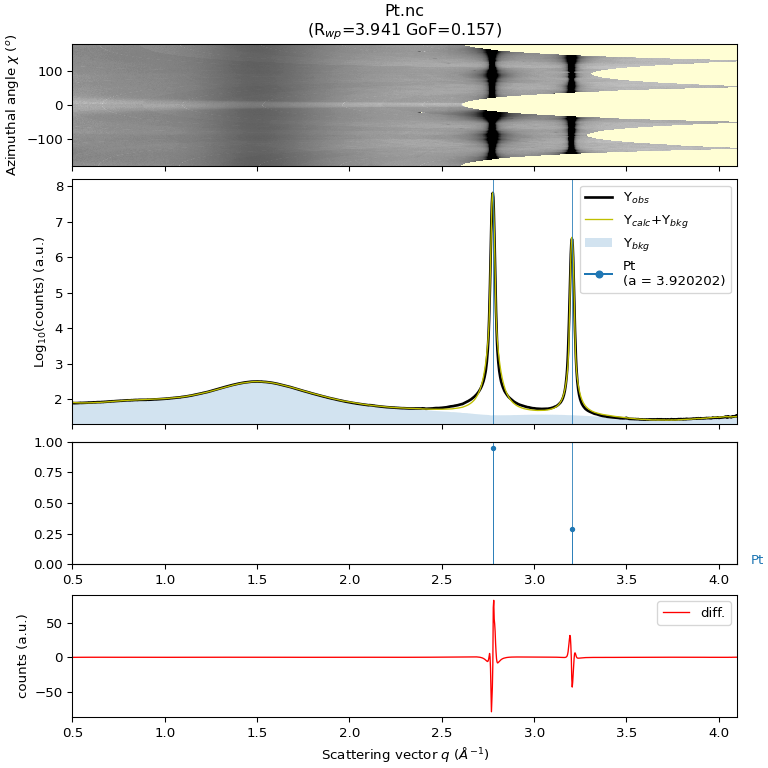

In [19]:
def refinement_recipe(gpx):

    refine_background(gpx,num_coeffs=5,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)
    refine_background(gpx,num_coeffs=10,set_to_false=True)

    gpx.save()
    return gpx


nc_path = 'Pt.nc'

phases = [
    {'cif_abs_path':'Pt.cif','phase_name':'Pt','scale':1},
    ]

with HiddenPrints():
    [gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[0.5,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )


In [20]:
print_all_cell_consts(gpx)

Pt
    a:
        3.920201804625991
    b:
        3.920201804625991
    c:
        3.920201804625991


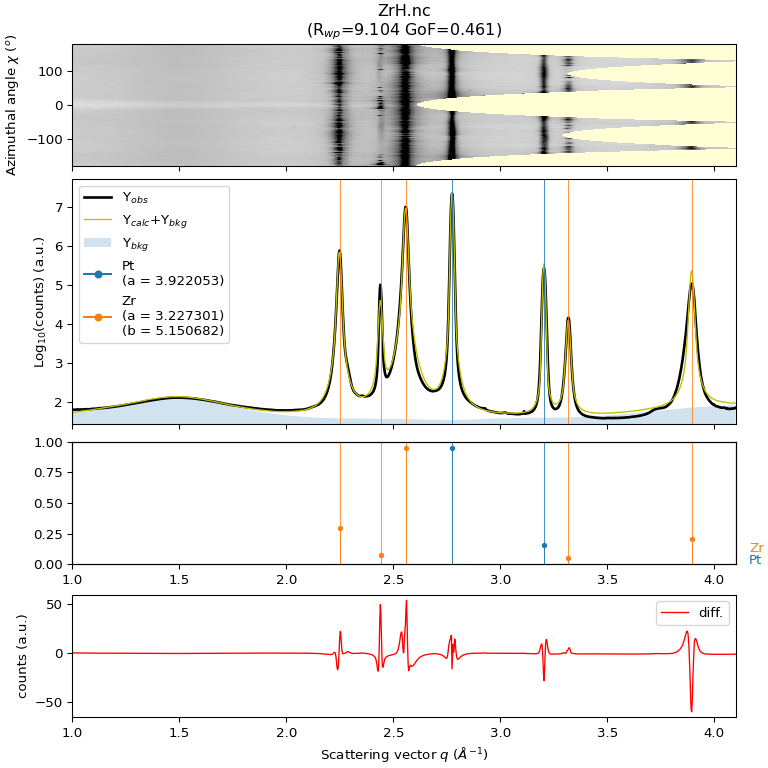

In [21]:
def refinement_recipe(gpx):

    refine_background(gpx,num_coeffs=3,set_to_false=True)
    set_LeBail(gpx,LeBail=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)
    refine_background(gpx,num_coeffs=5,set_to_false=True)
    refine_cell_params(gpx,set_to_false=True)
    refine_size_broadening(gpx,set_to_false=True)
    refine_strain_broadening(gpx,set_to_false=True)

    gpx.save()
    return gpx



nc_path = 'ZrH.nc'

phases = [
    {'cif_abs_path':'Pt.cif','phase_name':'Pt','scale':1},
    {'cif_abs_path':'Zr.cif','phase_name':'Zr','scale':1},
    ]

with HiddenPrints():
    [gpx,ds] = refiner(nc_path,
            phases,
            da_input_bkg=da_input_bkg,
            q_range=[1,4.1],
            gsas2_scratch  = 'gsas2_scratch',
            refinement_recipe = refinement_recipe,
            update_ds = True
            )


In [22]:
print_all_cell_consts(gpx)

Pt
    a:
        3.9220532705667033
    b:
        3.9220532705667033
    c:
        3.9220532705667033
Zr
    a:
        3.227300847722942
    b:
        3.227300847722942
    c:
        5.150682067357592
